In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd

metadata = pd.read_csv('//content/gdrive/MyDrive/Part 2/Data/metadata_BR00116991.csv')

print(metadata.head())

   Unnamed: 0                FileName_OrigRNA  Metadata_ChannelID  \
0           0  r01c01f01p01-ch3sk1fk1fl1.tiff                   5   
1           1  r01c01f02p01-ch3sk1fk1fl1.tiff                   5   
2           2  r01c01f03p01-ch3sk1fk1fl1.tiff                   5   
3           3  r01c01f04p01-ch3sk1fk1fl1.tiff                   5   
4           4  r01c01f05p01-ch3sk1fk1fl1.tiff                   5   

  Metadata_Plate Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  \
0     BR00116991           A01              1               0.134679   
1     BR00116991           A01              2               0.134679   
2     BR00116991           A01              3               0.134673   
3     BR00116991           A01              4               0.134674   
4     BR00116991           A01              5               0.134681   

   Metadata_PositionX  Metadata_PositionY  Metadata_PositionZ  Metadata_Row  \
0           -0.000323            0.000323           -0.000002            

In [3]:
print(metadata['Metadata_pert_iname'].value_counts())

Metadata_pert_iname
DMSO            576
AZD7762          18
buparlisib       18
thioguanine      18
CYT-997          18
               ... 
halopemide        9
quinidine         9
dyphylline        9
epothilone-b      9
aripiprazole      9
Name: count, Length: 304, dtype: int64


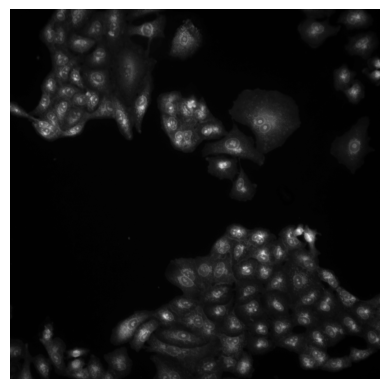

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display a sample image
img = Image.open('/content/gdrive/MyDrive/downsampled_data/r01c01f01_median_aggregated.tiff')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img_transformed = transform(img)

In [6]:
img_transformed

tensor([[[-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9922],
         [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9922],
         [-0.9843, -0.9843, -0.9843,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.9373, -0.9373, -0.9529,  ..., -0.9843, -0.9843, -0.9922],
         [-0.9373, -0.9373, -0.9373,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9137, -0.9373, -0.9294,  ..., -0.9922, -0.9922, -0.9922]]])

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

metadata['label'] = label_encoder.fit_transform(metadata['Metadata_pert_iname'])


In [12]:
def get_prefix(filename):
    return filename.split('p01-')[0]
metadata['prefix'] = metadata['FileName_OrigRNA'].apply(get_prefix)
# Just plug out the part so that we can match with our images!

In [13]:
import os
import pandas as pd

def get_prefixImg(filename):
    return filename.split('_')[0]
image_dir = '/content/gdrive/MyDrive/downsampled_data/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tiff')]
image_df = pd.DataFrame({'file_path': [os.path.join(image_dir, f) for f in image_files]})
image_df['prefix'] = image_df['file_path'].apply(lambda x: get_prefixImg(os.path.basename(x)))

In [14]:
merged_df = pd.merge(image_df, metadata, on='prefix', how='inner')
print(merged_df.head())

                                           file_path     prefix  Unnamed: 0  \
0  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c05f08        2203   
1  /content/gdrive/MyDrive/downsampled_data/r05c2...  r05c22f06        1058   
2  /content/gdrive/MyDrive/downsampled_data/r01c2...  r01c20f02         172   
3  /content/gdrive/MyDrive/downsampled_data/r12c1...  r12c17f08        2527   
4  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c02f09        2177   

                 FileName_OrigRNA  Metadata_ChannelID Metadata_Plate  \
0  r11c05f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
1  r05c22f06p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
2  r01c20f02p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
3  r12c17f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
4  r11c02f09p01-ch3sk1fk1fl1.tiff                   5     BR00116991   

  Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  Metadata_PositionX  \
0           K05

In [15]:
from torchvision import transforms
from PIL import Image
import torch

# Used the same transform pipeline as what we had for example image (and since it worked!)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformed_images = []
labels = []

for idx, row in merged_df.iterrows():
    #if idx % 100 == 0:
    print("we're processing image:", idx, "out of", "2877")
    img = Image.open(row['file_path'])

    img_transformed = transform(img)

    transformed_images.append(img_transformed)
    labels.append(row['label'])

transformed_images_tensor = torch.stack(transformed_images)
labels_tensor = torch.tensor(labels)

print("Number of transformed images:", len(transformed_images))
print("Shape of transformed image tensor:", transformed_images_tensor.shape)


we're processing image: 0 out of 2877
we're processing image: 1 out of 2877
we're processing image: 2 out of 2877
we're processing image: 3 out of 2877
we're processing image: 4 out of 2877
we're processing image: 5 out of 2877
we're processing image: 6 out of 2877
we're processing image: 7 out of 2877
we're processing image: 8 out of 2877
we're processing image: 9 out of 2877
we're processing image: 10 out of 2877
we're processing image: 11 out of 2877
we're processing image: 12 out of 2877
we're processing image: 13 out of 2877
we're processing image: 14 out of 2877
we're processing image: 15 out of 2877
we're processing image: 16 out of 2877
we're processing image: 17 out of 2877
we're processing image: 18 out of 2877
we're processing image: 19 out of 2877
we're processing image: 20 out of 2877
we're processing image: 21 out of 2877
we're processing image: 22 out of 2877
we're processing image: 23 out of 2877
we're processing image: 24 out of 2877
we're processing image: 25 out of 2

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_classes = merged_df['label'].nunique()
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
print(device)

cuda


In [18]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_df, val_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['label'], random_state=42)
unique_labels = sorted(merged_df['label'].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

train_df['mapped_label'] = train_df['label'].map(label_mapping)
val_df['mapped_label'] = val_df['label'].map(label_mapping)


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx]['mapped_label']
        return image, label

print("Train Labels:", train_df['mapped_label'].unique())
print("Validation Labels:", val_df['mapped_label'].unique())


# To be safe
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageDataset(train_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Train Labels: [ 38  37  39 244  36  68 133 148 249  22 186 161  65 229 207 187  32 195
 240 182  54 231  48 123 174   9   4 202 190  42 128 216 115 107  10 157
  18  23 170  90   5  16 162 239   1   3 217  53 215 219  87  82 134 105
 213  58  29  80  93  55  92 142  91  12 101 203 225  81 206 137  46  97
 173  13 223  51 120  41 222  25 112 152 185 226 113 127  73  74  43 191
 243 122   7  17  77  78  28 235  21  31  44 116  88  61 130 155 144  72
  76 149 104  62  70  95  19 111 234 184 180 245 114 106  98  30  27 147
  34 125  94 212 150 160  59 183 214 194  50 138  66 176 118 189 172 199
 136 181 154 131 100 124 171   0 109 103 241 224 117   2 145 164  96 153
 132 159 110 143   6 204 228  45 232 220 166 177  69 196 102 209 197 210
 126 200 121  64  49  83 178  15 198   8 139 163 140  99 179  57  67  89
 129  14 135 167 238 175 236 192  86 169  11  33 151  84 233 221 230  71
  26 146 247  40 156 211 218 188 165  56 246 205 119 193  20 242 201  85
  52 158  75 208  24  60  63 141  47 

In [20]:
num_classes = len(label_mapping)  # Number of unique labels
print(f"Number of classes: {num_classes}")

Number of classes: 250


In [22]:
# As what we did for HW C+D
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/10], Loss: 4.6870
Validation Accuracy: 0.1667
Epoch [2/10], Loss: 4.3846
Validation Accuracy: 0.1632
Epoch [3/10], Loss: 4.0797
Validation Accuracy: 0.1597
Epoch [4/10], Loss: 3.7458
Validation Accuracy: 0.1545
Epoch [5/10], Loss: 3.1993
Validation Accuracy: 0.1892
Epoch [6/10], Loss: 2.4527
Validation Accuracy: 0.0677
Epoch [7/10], Loss: 1.4128
Validation Accuracy: 0.0851
Epoch [8/10], Loss: 0.5685
Validation Accuracy: 0.0747
Epoch [9/10], Loss: 0.1788
Validation Accuracy: 0.1319
Epoch [10/10], Loss: 0.0432
Validation Accuracy: 0.1163


In [28]:
test_image_path = '/content/gdrive/MyDrive/Part 2/Data/example_data/r04c08f05p01-compound-FK866.tiff'
test_image = Image.open(test_image_path)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_image_tensor = transform(test_image).unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(test_image_tensor)
    _, predicted_label_idx = torch.max(output, 1)

predicted_label = predicted_label_idx.item()
predicted_drug_treatment = {v: k for k, v in label_mapping.items()}.get(predicted_label, "Label not found")
print(f"Predicted Drug Treatment for the test image: {predicted_drug_treatment}")

Predicted Drug Treatment for the test image: 130


In [26]:
predicted_drug_treatment_name = [name for name, label in label_mapping.items() if label == predicted_label]

if predicted_drug_treatment_name:
    print(f"Predicted Drug Treatment for the test image: {predicted_drug_treatment_name[0]}")
else:
    print("No matching drug treatment found for the label.")


Predicted Drug Treatment for the test image: 148


In [32]:
metadata['Metadata_pert_iname']

,Metadata_pert_iname
0,gabapentin-enacarbil
1,gabapentin-enacarbil
2,gabapentin-enacarbil
3,gabapentin-enacarbil
4,gabapentin-enacarbil
...,...
3451,aripiprazole
3452,aripiprazole
3453,aripiprazole
3454,aripiprazole


In [33]:
metadata['label']

,label
0,211
1,211
2,211
3,211
4,211
...,...
3451,153
3452,153
3453,153
3454,153


In [34]:
rows_with_label_148 = merged_df[merged_df['label'] == 148]
print(rows_with_label_148)

                                              file_path     prefix  \
64    /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f05   
324   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f03   
325   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f06   
875   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f09   
1568  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f07   
1584  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f02   
2147  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f01   
2159  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f04   
2165  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f08   

      Unnamed: 0                FileName_OrigRNA  Metadata_ChannelID  \
64            22  r01c03f05p01-ch3sk1fk1fl1.tiff                   5   
324           20  r01c03f03p01-ch3sk1fk1fl1.tiff                   5   
325           23  r01c03f06p01-ch3sk1fk1fl1.tiff                   5   
875        

Thus we get amlodipine.